In [1]:
import numpy as np
import torch
from mpc_mpnet_planner import MPCMPNetPlanner
from matplotlib import pyplot as plt

import pickle
 
def load_data(model, env, traj_id):
    filepath = lambda var: "/media/arclabdl1/HD1/Linjun/data/kinodynamic/{model}/{env}/{var}_{id}.pkl".format(model=model,env=env, var=var, id=traj_id)      
    load_pkl = lambda var: pickle.load(open(filepath(var), "rb"))
    keys = ["control", "path", "start_goal", "time", 'cost']
    return dict(zip(keys, [load_pkl(key) for key in keys]))
 


In [79]:
env_id = 0
traj_id = 10
data = load_data('acrobot_obs', env_id, traj_id)
ref_path = data['path']
env_vox = torch.from_numpy(np.load('mpnet/sst_envs/acrobot_obs_env_vox.npy')[env_id]).unsqueeze(0).float()

n_t = 10
state_dim = 4
control_dim = 1
weights = np.ones(state_dim)*1
weights[2:] = 0.25
n_sample = 8192
n_elite = 32
t = 1e-1
dt = 2e-2

mu_t, sigma_t = 4e-2, 4e-2
t_min, t_max = 0, 4e-1

mu_u = np.zeros((n_t*control_dim))
sigma_u_diag = np.ones(n_t*control_dim)
sigma_u_diag[:] = 8
sigma_u = np.diag(sigma_u_diag)
params = {
    'n_sample': n_sample,
    'n_elite': n_elite,
    'n_t': n_t,
    'weights': weights,
    'mu_u': mu_u,
    'sigma_u': sigma_u,
    't': t,
    'dt': dt,
    
    'mu_t': np.ones(n_t) * mu_t,
    'sigma_t': np.identity(n_t)*sigma_t,
    't_min': t_min,
    't_max': t_max,
    
    'state_dim': state_dim,
    'control_dim': control_dim,
    'converge_radius': 3e-1,
    'drop_radius':1,
    'goal_radius':2,
    'max_it': 10,
    'rolling_count': n_t,
    'bk_it': 2,
    'final_goal': ref_path[-1],
    'mpc_mode': 'solve',
#     'mpc_mode': 'rolling',    
}

In [86]:
mpc_mpnet = MPCMPNetPlanner(params,
                             ref_path[0], 
                             ref_path[-1],
                             env_vox,
                             system="acrobot_obs",
#                              setup="default_norm",
#                              setup="default_norm_aug",
                             setup="norm_nodiff_noaug_20step2e-2",
                             ep=500,
                             obs_list=None, verbose=True)
# mpc_mpnet.mpnet.eval()
mpc_mpnet.mpnet.train()

while not mpc_mpnet.reached:
    mpc_mpnet.plan_waypoints()
path = np.array(mpc_mpnet.path)
print(len(path))


[64.16235413]
[63.7727293]
[64.02606747]
[63.91964711]
[63.91242804]
[64.16817577]
[63.26344812]
[62.06737844]
[63.74905672]
[64.03376464]
[64.11504692]
[64.15118256]
[64.20658413]
[64.20061524]
[64.10034576]
[63.70051449]
[63.21259552]
[61.50358]
[61.33565983]
[56.41109995]
[58.36416816]
[61.21802495]
[55.96102811]
[35.31543172]
[8.92045995]
reached, goal distance: [0.]
26


In [87]:
# path = path[range(len(path))[::3],:]
print(len(path))

26


<IPython.core.display.Javascript object>


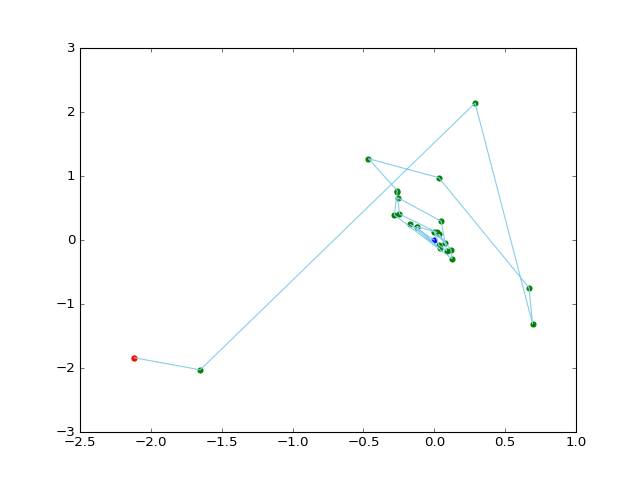

[[-2.11780038 -1.8392837  -0.52997405  0.82624102]] [[-2.11780038 -1.8392837  -0.52997405  0.82624102]]


In [88]:
%matplotlib notebook
plt.plot(path[:,0], path[:,1], color='skyblue')

plt.scatter(mpc_mpnet.state[:,0], mpc_mpnet.state[:,1], color='orange')
plt.scatter(ref_path[0,0], ref_path[0,1], color='blue')
plt.scatter(ref_path[-1,0], ref_path[-1,1], color='red')
samples = np.array(mpc_mpnet.samples)
plt.scatter(samples[:,0], samples[:,1], color='green')

print(mpc_mpnet.state, mpc_mpnet.goal)

In [89]:
x = path[0].copy()
trajs = []
for i in range(len(path)-1):
    print('node:',i)
    x, min_loss, traj, collision, cost= mpc_mpnet.mpc.solve(x.copy(), path[i+1].copy())
    
    print(x)
    trajs.append(traj)
#     if min_loss > mpc_mpnet.params['drop_radius']:
#         break
    

node: 0
0.11828277184525614 inf
converged at  0
loss: [0.05914139]
[-0.11291126  0.24471747 -0.55302363  1.24364099]
node: 1
1.1791298726020105 inf
1.0957641666786988 1.1791298726020105
1.0925906471874602 1.0957641666786988
1.0923905422612605 1.0925906471874602
1.0923902898960238 1.0923905422612605
1.092390289867076 1.0923902898960238
1.092390289867073 1.092390289867076
1.0923902898670728 1.092390289867073
1.0923902898670728 1.0923902898670728
1.092390289867073 1.0923902898670728
1.092390289867073 1.0923902898670728
converged at  1
loss: [0.1850111]
[ 0.03991775  0.03157102  0.25653692 -0.3525754 ]
node: 2
0.34477444393955575 inf
0.34268201359673206 0.34477444393955575
0.342678686805091 0.34268201359673206
0.3426784146565518 0.342678686805091
0.34267841152437956 0.3426784146565518
0.3426784115060114 0.34267841152437956
0.3426784115058762 0.3426784115060114
0.342678411505876 0.3426784115058762
0.34267841150587597 0.342678411505876
0.34267841150587597 0.34267841150587597
0.34267841150587

In [36]:
%matplotlib notebook
i = 4
ti = np.array(trajs[i])
plt.plot(ti[:,0], ti[:,1], color='skyblue')
plt.scatter(ti[0,0], ti[0,1], color='blue')
plt.scatter(ti[-1,0], ti[-1,1], color='red')
plt.scatter(path[i+1,0], path[i+1,1], color='green')

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

IndexError: list index out of range

In [12]:
new_start = np.expand_dims(x.copy(),axis=0)
mpc_mpnet.state = new_start.copy()
mpc_mpnet.reached = False
mpc_mpnet.path = []
while not mpc_mpnet.reached:
    mpc_mpnet.plan_waypoints()

[22.7113878]
[14.99413028]
[25.30419201]
[26.89983809]
[28.89898983]
[35.87667062]
[64.04082365]
[59.41354875]
[37.09627858]
[34.39374252]
[15.3756621]
[11.59299195]
[3.44707538]
reached, goal distance: [0.]


In [85]:
x = path[0].copy()
trajs = []
for i in range(len(path)-1):
    print('node:',i)
    x, min_loss, traj, collision, cost = mpc_mpnet.mpc.solve(x.copy(), path[i+1].copy())
    
    print(x)
    trajs.append(traj)
    if min_loss > mpc_mpnet.params['drop_radius']:
        break
path = np.array(mpc_mpnet.path)


node: 0
0.36226400546973825 inf
0.3620612150757749 0.36226400546973825
0.36206121428171467 0.3620612150757749
0.3620612142816958 0.36206121428171467
0.3620612142816955 0.3620612142816958
0.3620612142816955 0.3620612142816955
0.36206121428169546 0.3620612142816955
0.36206121428169546 0.36206121428169546
0.36206121428169546 0.36206121428169546
0.3620612142816955 0.36206121428169546
0.36206121428169546 0.36206121428169546
converged at  0
loss: [0.18103061]
[-0.18077286  0.3946611  -0.74810807  1.71843235]
node: 1
6.054033185120076 inf
2.73611664966279 6.054033185120076
2.7329909620461685 2.73611664966279
2.7341994736612003 2.7329909620461685
2.7265652481422635 2.7329909620461685
2.7251328366037435 2.7265652481422635
2.7249187071541137 2.7251328366037435
2.7249058121454017 2.7249187071541137
2.7249055887681246 2.7249058121454017
2.7249055806310043 2.7249055887681246
2.7249055799918964 2.7249055806310043
converged at  1
loss: [0.25613064]
[ 0.63685925 -1.18153344  0.80783811 -2.33944587]
no